In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from IPython.display import Markdown, display

# Datasets
from aif360.datasets import StandardDataset

# from PhysionetDataset.py import PhysionetDataset.py
# Dataset = PhysionetDataset.py


# Fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric

# Explainers
from aif360.explainers import MetricTextExplainer

# Scalers
from sklearn.preprocessing import StandardScaler

# Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# Bias mitigation techniques
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import PrejudiceRemover

In [2]:
#Features: https://journals.lww.com/ccmjournal/_layouts/15/oaks.journals/ImageView.aspx?k=ccmjournal:2020:02000:00010&i=T1&year=2020&issue=02000&article=00010&type=Fulltext

#Data:https://archive.physionet.org/users/shared/challenge-2019/

#Extensive pre-processing on Sepsis_PreProcess.ipynb

In [5]:

np.random.seed(1)

default_mappings = {
    'label_maps': [{1.0: '1'}],
    'protected_attribute_maps': [{1.0: 'Male', 0.0: 'Female'}]
}


filepath = r'C:\Users\sujin\Documents\College\PhD_Project\Project\Sepsis_NoColumns.csv'
        
filepath2 = r'C:\Users\sujin\Documents\College\PhD_Project\Project\Sepsis.csv'
df2 = pd.read_csv(filepath2)
df2.columns

class PhysionetDataset(StandardDataset):

    def __init__(self, label_name='SepsisLabel',
                 favorable_classes=[1],
                 protected_attribute_names=['Gender'],
                 privileged_classes=[[1]],
                 instance_weights_name=None,
                 categorical_features=[],
                 features_to_keep=[], features_to_drop=[],
                 na_values=[], custom_preprocessing=None,
                 metadata=default_mappings):


        column_names = df2.columns
        try:
            df = pd.read_csv(filepath, header=None, names=column_names,
                             na_values=na_values)
            
        except IOError as err:
            print("IOError: {}".format(err))
            print("To use this class, please download the following files:")
            print("\n\thttps://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data")
            print("\thttps://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.doc")
            print("\nand place them, as-is, in the folder:")
            print("\n\t{}\n".format(os.path.abspath(os.path.join(
                os.path.abspath(__file__), '..', '..', 'data', 'raw', 'german'))))
            import sys
            sys.exit(1)

        super(PhysionetDataset, self).__init__(df=df, label_name=label_name,
                                               favorable_classes=favorable_classes,
                                               protected_attribute_names=protected_attribute_names,
                                               privileged_classes=privileged_classes,
                                               instance_weights_name=instance_weights_name,
                                               categorical_features=categorical_features,
                                               features_to_keep=features_to_keep,
                                               features_to_drop=features_to_drop, na_values=na_values,
                                               custom_preprocessing=custom_preprocessing, metadata=metadata)


In [6]:
# 3.1. Load data & create splits for learning/validating/testing model¶


(dataset_orig_train, dataset_orig_val, dataset_orig_test) = PhysionetDataset().split([0.5, 0.8], shuffle=True)

sens_ind = 0
sens_attr = dataset_orig_train.protected_attribute_names[sens_ind]

unprivileged_groups = [{sens_attr: v} for v in
                       dataset_orig_train.unprivileged_protected_attributes[sens_ind]]

privileged_groups = [{sens_attr: v} for v in
                     dataset_orig_train.privileged_protected_attributes[sens_ind]]


def describe(train=None, val=None, test=None):
    if train is not None:
        display(Markdown("#### Training Dataset shape"))
        print(train.features.shape)
    if val is not None:
        display(Markdown("#### Validation Dataset shape"))
        print(val.features.shape)
    display(Markdown("#### Test Dataset shape"))
    print(test.features.shape)
    display(Markdown("#### Favorable and unfavorable labels"))
    print(test.favorable_label, test.unfavorable_label)
    display(Markdown("#### Protected attribute names"))
    print(test.protected_attribute_names)
    display(Markdown("#### Privileged and unprivileged protected attribute values"))
    print(test.privileged_protected_attributes,
          test.unprivileged_protected_attributes)
    display(Markdown("#### Dataset feature names"))
    print(test.feature_names)


describe(dataset_orig_train, dataset_orig_val, dataset_orig_test)

metric_orig_train = BinaryLabelDatasetMetric(
    dataset_orig_train,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups)
explainer_orig_panel19_train = MetricTextExplainer(metric_orig_train)

print(explainer_orig_panel19_train.disparate_impact())

#### Training Dataset shape

(5880, 14)


#### Validation Dataset shape

(3528, 14)


#### Test Dataset shape

(2352, 14)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['Gender']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'FiO2', 'pH', 'Glucose', 'Age', 'Gender', 'HospAdmTime', 'ICULOS']
Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.9294325440019716


In [7]:
# 3.2. Learning a Logistic Regression (LR) classifier on original data¶
# 3.2.1. Training LR model on original data

dataset = dataset_orig_train
model = make_pipeline(StandardScaler(),
                      LogisticRegression(solver='liblinear', random_state=1))
fit_params = {'logisticregression__sample_weight': dataset.instance_weights}

lr_orig = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

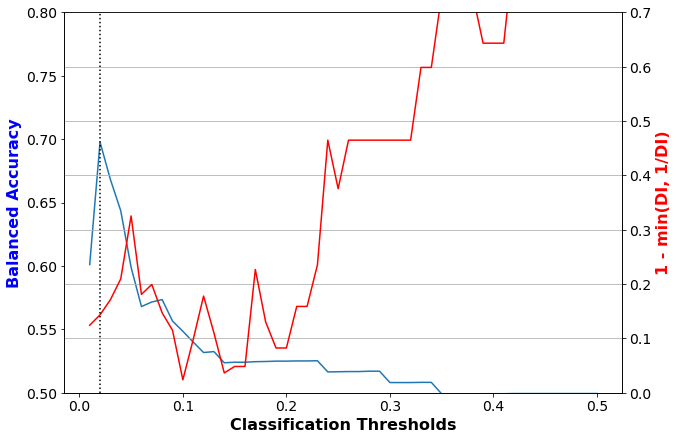

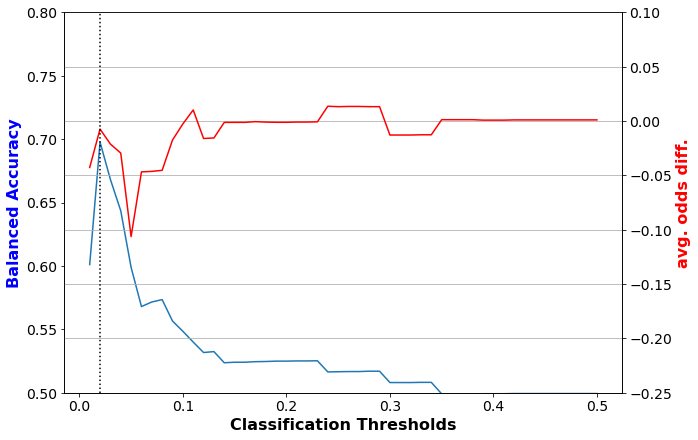

Validation Scores:
Threshold corresponding to Best balanced accuracy: 0.0200
Best balanced accuracy: 0.6977
Corresponding 1-min(DI, 1/DI) value: 0.1434
Corresponding average odds difference value: -0.0074
Corresponding statistical parity difference value: -0.0346
Corresponding equal opportunity difference value: 0.0205
Corresponding Theil index value: 0.0572


In [8]:
# 3.2.2. Validating LR model on original data¶

from collections import defaultdict


def test(dataset, model, thresh_arr):
    try:
        # sklearn classifier
        y_val_pred_prob = model.predict_proba(dataset.features)
        pos_ind = np.where(model.classes_ == dataset.favorable_label)[0][0]
    except AttributeError:
        # aif360 inprocessing algorithm
        y_val_pred_prob = model.predict(dataset).scores
        pos_ind = 0

    metric_arrs = defaultdict(list)
    for thresh in thresh_arr:
        y_val_pred = (y_val_pred_prob[:, pos_ind] > thresh).astype(np.float64)

        dataset_pred = dataset.copy()
        dataset_pred.labels = y_val_pred
        metric = ClassificationMetric(
            dataset, dataset_pred,
            unprivileged_groups=unprivileged_groups,
            privileged_groups=privileged_groups)

        metric_arrs['bal_acc'].append((metric.true_positive_rate()
                                       + metric.true_negative_rate()) / 2)
        metric_arrs['avg_odds_diff'].append(metric.average_odds_difference())
        metric_arrs['disp_imp'].append(metric.disparate_impact())
        metric_arrs['stat_par_diff'].append(metric.statistical_parity_difference())
        metric_arrs['eq_opp_diff'].append(metric.equal_opportunity_difference())
        metric_arrs['theil_ind'].append(metric.theil_index())

    return metric_arrs


thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=dataset_orig_val,
                   model=lr_orig,
                   thresh_arr=thresh_arr)
lr_orig_best_ind = np.argmax(val_metrics['bal_acc'])


def plot(x, x_name, y_left, y_left_name, y_right, y_right_name):
    fig, ax1 = plt.subplots(figsize=(10, 7))
    ax1.plot(x, y_left)
    ax1.set_xlabel(x_name, fontsize=16, fontweight='bold')
    ax1.set_ylabel(y_left_name, color='b', fontsize=16, fontweight='bold')
    ax1.xaxis.set_tick_params(labelsize=14)
    ax1.yaxis.set_tick_params(labelsize=14)
    ax1.set_ylim(0.5, 0.8)

    ax2 = ax1.twinx()
    ax2.plot(x, y_right, color='r')
    ax2.set_ylabel(y_right_name, color='r', fontsize=16, fontweight='bold')
    if 'DI' in y_right_name:
        ax2.set_ylim(0., 0.7)
    else:
        ax2.set_ylim(-0.25, 0.1)

    best_ind = np.argmax(y_left)
    ax2.axvline(np.array(x)[best_ind], color='k', linestyle=':')
    ax2.yaxis.set_tick_params(labelsize=14)
    ax2.grid(True)
    plt.show()
    
    
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1 / disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

def describe_metrics(metrics, thresh_arr):
    best_ind = np.argmax(metrics['bal_acc'])
    print("Threshold corresponding to Best balanced accuracy: {:6.4f}".format(thresh_arr[best_ind]))
    print("Best balanced accuracy: {:6.4f}".format(metrics['bal_acc'][best_ind]))
#     disp_imp_at_best_ind = np.abs(1 - np.array(metrics['disp_imp']))[best_ind]
    disp_imp_at_best_ind = 1 - min(metrics['disp_imp'][best_ind], 1/metrics['disp_imp'][best_ind])
    print("Corresponding 1-min(DI, 1/DI) value: {:6.4f}".format(disp_imp_at_best_ind))
    print("Corresponding average odds difference value: {:6.4f}".format(metrics['avg_odds_diff'][best_ind]))
    print("Corresponding statistical parity difference value: {:6.4f}".format(metrics['stat_par_diff'][best_ind]))
    print("Corresponding equal opportunity difference value: {:6.4f}".format(metrics['eq_opp_diff'][best_ind]))
    print("Corresponding Theil index value: {:6.4f}".format(metrics['theil_ind'][best_ind]))


print("Validation Scores:")
describe_metrics(val_metrics, thresh_arr)

In [9]:
#3.2.3. Testing LR model on original data¶

print("Test Scores:")
lr_orig_metrics = test(dataset=dataset_orig_test,
                       model=lr_orig,
                       thresh_arr=[thresh_arr[lr_orig_best_ind]])

describe_metrics(lr_orig_metrics, [thresh_arr[lr_orig_best_ind]])

#4. Bias mitigation using pre-processing technique - Reweighing¶

#4.1. Transform data¶
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_transf_train = RW.fit_transform(dataset_orig_train)

#Metrics for transformed data

metric_transf_train = BinaryLabelDatasetMetric(
        dataset_transf_train,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)
explainer_transf_train = MetricTextExplainer(metric_transf_train)

print(explainer_transf_train.disparate_impact())

Test Scores:
Threshold corresponding to Best balanced accuracy: 0.0200
Best balanced accuracy: 0.6585
Corresponding 1-min(DI, 1/DI) value: 0.1823
Corresponding average odds difference value: -0.0979
Corresponding statistical parity difference value: -0.0487
Corresponding equal opportunity difference value: -0.1487
Corresponding Theil index value: 0.0610
Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.9999999999999998


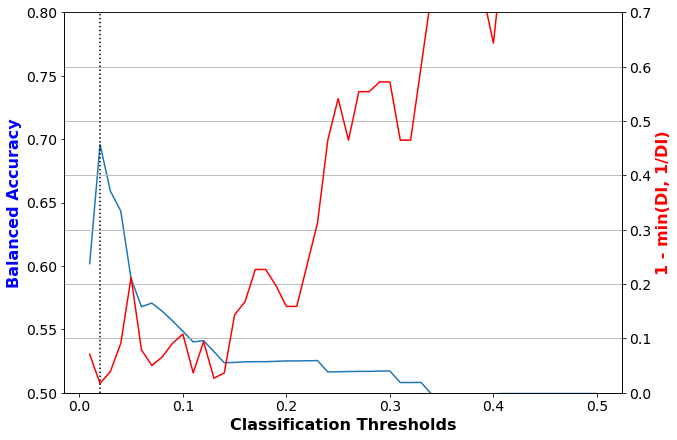

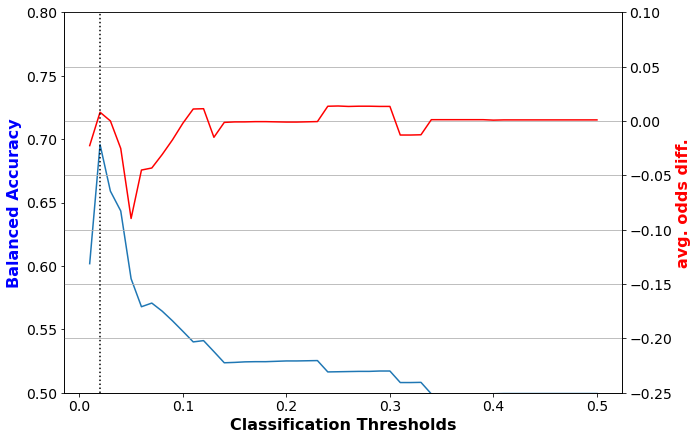

Threshold corresponding to Best balanced accuracy: 0.0200
Best balanced accuracy: 0.6958
Corresponding 1-min(DI, 1/DI) value: 0.0172
Corresponding average odds difference value: 0.0081
Corresponding statistical parity difference value: -0.0040
Corresponding equal opportunity difference value: 0.0205
Corresponding Theil index value: 0.0576


In [10]:
#4.2. Learning a Logistic Regression (LR) classifier on data transformed by reweighing¶

#4.2.1. Training LR model after reweighing¶
dataset = dataset_transf_train
model = make_pipeline(StandardScaler(),
                      LogisticRegression(solver='liblinear', random_state=1))
fit_params = {'logisticregression__sample_weight': dataset.instance_weights}
lr_transf = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

#4.2.2. Validating LR model after reweighing¶


thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=dataset_orig_val,
                   model=lr_transf,
                   thresh_arr=thresh_arr)
lr_transf_best_ind = np.argmax(val_metrics['bal_acc'])

disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)

plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

describe_metrics(val_metrics, thresh_arr)


In [11]:
#4.2.3. Testing LR model after reweighing¶
lr_transf_metrics = test(dataset=dataset_orig_test,
                         model=lr_transf,
                         thresh_arr=[thresh_arr[lr_transf_best_ind]])
describe_metrics(lr_transf_metrics, [thresh_arr[lr_transf_best_ind]])


Threshold corresponding to Best balanced accuracy: 0.0200
Best balanced accuracy: 0.6711
Corresponding 1-min(DI, 1/DI) value: 0.0653
Corresponding average odds difference value: -0.0488
Corresponding statistical parity difference value: -0.0167
Corresponding equal opportunity difference value: -0.0821
Corresponding Theil index value: 0.0605


divide by zero encountered in true_divide


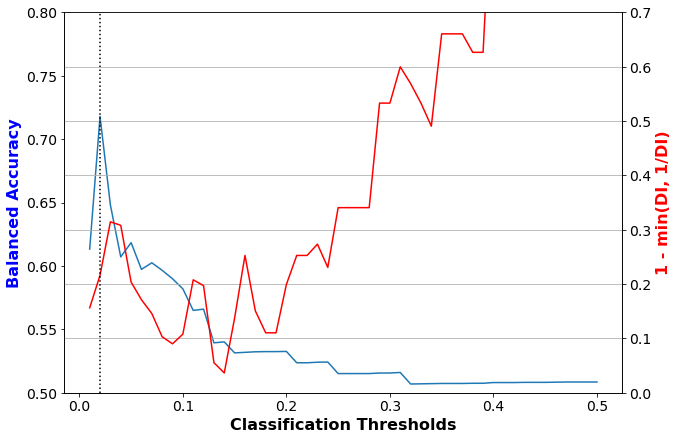

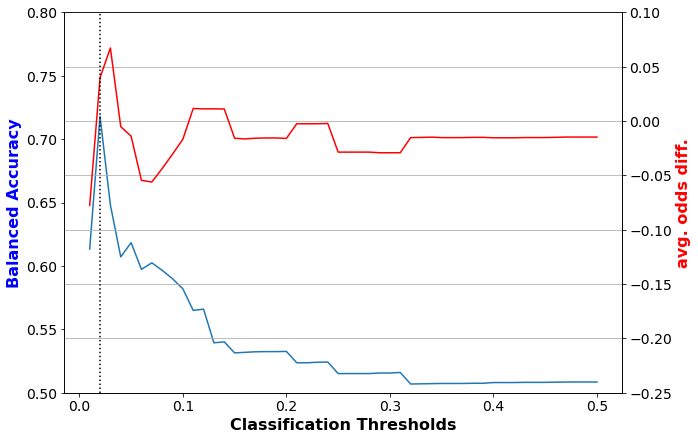

Threshold corresponding to Best balanced accuracy: 0.0200
Best balanced accuracy: 0.7179
Corresponding 1-min(DI, 1/DI) value: 0.2163
Corresponding average odds difference value: 0.0399
Corresponding statistical parity difference value: 0.0614
Corresponding equal opportunity difference value: 0.0175
Corresponding Theil index value: 0.0578


In [12]:
#5. Bias mitigation using in-processing technique - Prejudice Remover (PR)¶

#5.1.1. Training a PR model
model = PrejudiceRemover(sensitive_attr=sens_attr, eta=25.0)
pr_orig_scaler = StandardScaler()

dataset = dataset_orig_train.copy()
dataset.features = pr_orig_scaler.fit_transform(dataset.features)

pr_orig = model.fit(dataset)

#5.1.2. Validating PR model¶

thresh_arr = np.linspace(0.01, 0.50, 50)

dataset = dataset_orig_val.copy()
dataset.features = pr_orig_scaler.transform(dataset.features)

val_metrics = test(dataset=dataset,
                   model=pr_orig,
                   thresh_arr=thresh_arr)
pr_orig_best_ind = np.argmax(val_metrics['bal_acc'])
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)

plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

describe_metrics(val_metrics, thresh_arr)


In [13]:
#5.1.3. Testing PR model¶

dataset = dataset_orig_test.copy()
dataset.features = pr_orig_scaler.transform(dataset.features)

pr_orig_metrics = test(dataset=dataset,
                       model=pr_orig,
                       thresh_arr=[thresh_arr[pr_orig_best_ind]])
describe_metrics(pr_orig_metrics, [thresh_arr[pr_orig_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.0200
Best balanced accuracy: 0.6158
Corresponding 1-min(DI, 1/DI) value: 0.0909
Corresponding average odds difference value: -0.0553
Corresponding statistical parity difference value: 0.0251
Corresponding equal opportunity difference value: -0.1385
Corresponding Theil index value: 0.0634


In [14]:
import pandas as pd
pd.set_option('display.multi_sparse', False)
results = [lr_orig_metrics, lr_transf_metrics,
            pr_orig_metrics]
debias = pd.Series([''] + ['Reweighing']
                 + ['Prejudice Remover'],
                   name='Bias Mitigator')
clf = pd.Series(['Logistic Regression']*2 + [''],
                name='Classifier')
pd.concat([pd.DataFrame(metrics) for metrics in results], axis=0).set_index([debias, clf])

,,bal_acc,avg_odds_diff,disp_imp,stat_par_diff,eq_opp_diff,theil_ind
Bias Mitigator,Classifier,,,,,,
,Logistic Regression,0.658463,-0.097881,0.817709,-0.048692,-0.148718,0.061042
Reweighing,Logistic Regression,0.671091,-0.048847,0.934702,-0.016661,-0.082051,0.060523
Prejudice Remover,,0.615819,-0.055268,1.099961,0.025106,-0.138462,0.063424


In [15]:
#Disparate Impact Remover

from aif360.algorithms.preprocessing import DisparateImpactRemover


In [16]:
#3.2.3. Testing LR model on original data¶

print("Test Scores:")
lr_orig_metrics = test(dataset=dataset_orig_test,
                       model=lr_orig,
                       thresh_arr=[thresh_arr[lr_orig_best_ind]])

describe_metrics(lr_orig_metrics, [thresh_arr[lr_orig_best_ind]])

#4. Bias mitigation using pre-processing technique - Disparate Impact Remover¶

#4.1. Transform data¶


di = DisparateImpactRemover(repair_level=1.0)
dataset_transf_train = di.fit_transform(dataset_orig_train)
dataset_transf_test = di.fit_transform(dataset_orig_test)

#Metrics for transformed data

metric_transf_train = BinaryLabelDatasetMetric(
        dataset_transf_train,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)
explainer_transf_train = MetricTextExplainer(metric_transf_train)

print(explainer_transf_train.disparate_impact())

Test Scores:
Threshold corresponding to Best balanced accuracy: 0.0200
Best balanced accuracy: 0.6585
Corresponding 1-min(DI, 1/DI) value: 0.1823
Corresponding average odds difference value: -0.0979
Corresponding statistical parity difference value: -0.0487
Corresponding equal opportunity difference value: -0.1487
Corresponding Theil index value: 0.0610
Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.9294325440019716


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


Threshold corresponding to Best balanced accuracy: 0.0200
Best balanced accuracy: 0.7029
Corresponding 1-min(DI, 1/DI) value: 0.0563
Corresponding average odds difference value: -0.0135
Corresponding statistical parity difference value: -0.0167
Corresponding equal opportunity difference value: -0.0102
Corresponding Theil index value: 0.0613


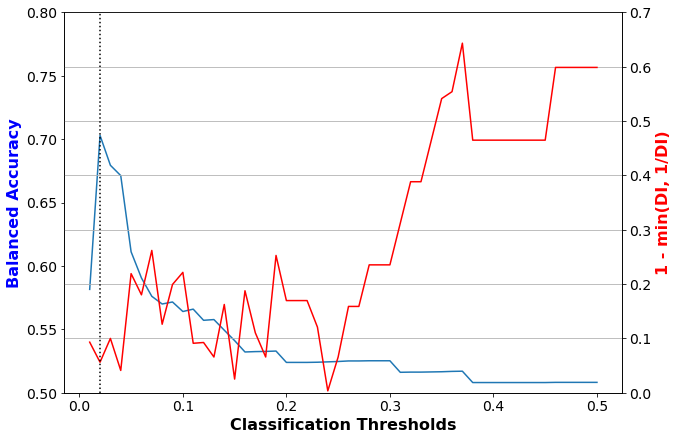

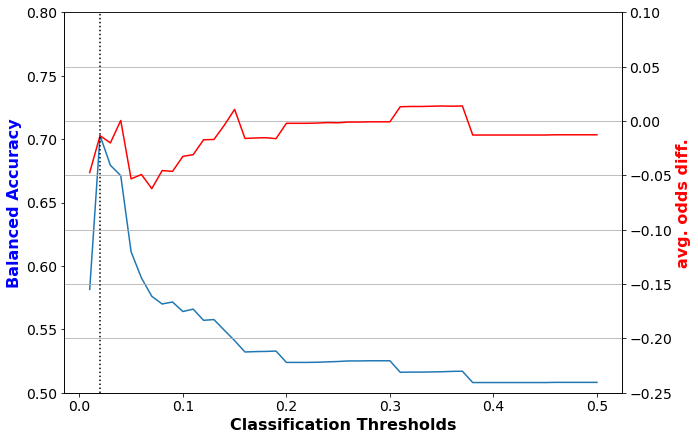

In [17]:
#4.2.1. Training LR model after Disparate Impact Remover¶
dataset = dataset_transf_train
model = make_pipeline(StandardScaler(),
                      LogisticRegression(solver='liblinear', random_state=1))
fit_params = {'logisticregression__sample_weight': dataset.instance_weights}
lr_transf = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

#4.2.2. Validating LR model after Disdparate impact Remover¶


thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=dataset_orig_val,
                   model=lr_transf,
                   thresh_arr=thresh_arr)
lr_transf_best_ind = np.argmax(val_metrics['bal_acc'])

disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)

plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

describe_metrics(val_metrics, thresh_arr)

In [18]:
#Test LR DIR Model

lr_metrics_DIR = test(dataset=dataset_orig_test,
                         model=lr_transf,
                         thresh_arr=[thresh_arr[lr_transf_best_ind]])
describe_metrics(lr_metrics_DIR, [thresh_arr[lr_transf_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.0200
Best balanced accuracy: 0.6763
Corresponding 1-min(DI, 1/DI) value: 0.1421
Corresponding average odds difference value: -0.0692
Corresponding statistical parity difference value: -0.0467
Corresponding equal opportunity difference value: -0.0923
Corresponding Theil index value: 0.0636


In [19]:
import pandas as pd
pd.set_option('display.multi_sparse', False)
results = [lr_orig_metrics, lr_transf_metrics,
            pr_orig_metrics, lr_metrics_DIR]
debias = pd.Series([''] + ['Reweighing']
                 + ['Prejudice Remover'] + ["Disparate Impact Remover"],
                   name='Bias Mitigator')
clf = pd.Series(['Logistic Regression']*2 + [''] + ["Logistic Regression"],
                name='Classifier')
pd.concat([pd.DataFrame(metrics) for metrics in results], axis=0).set_index([debias, clf])

,,bal_acc,avg_odds_diff,disp_imp,stat_par_diff,eq_opp_diff,theil_ind
Bias Mitigator,Classifier,,,,,,
,Logistic Regression,0.658463,-0.097881,0.817709,-0.048692,-0.148718,0.061042
Reweighing,Logistic Regression,0.671091,-0.048847,0.934702,-0.016661,-0.082051,0.060523
Prejudice Remover,,0.615819,-0.055268,1.099961,0.025106,-0.138462,0.063424
Disparate Impact Remover,Logistic Regression,0.676304,-0.069190,0.857918,-0.046731,-0.092308,0.063640


In [20]:
from aif360.algorithms.inprocessing.adversarial_debiasing import AdversarialDebiasing
from aif360.metrics import ClassificationMetric
from sklearn.preprocessing import MaxAbsScaler
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()


# Metric for the original dataset
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())
metric_orig_test = BinaryLabelDatasetMetric(dataset_orig_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_test.mean_difference())

#### Original training dataset

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.001328
Test set: Difference in mean outcomes between unprivileged and privileged groups = 0.000434


In [21]:
min_max_scaler = MaxAbsScaler()
dataset_orig_train.features = min_max_scaler.fit_transform(dataset_orig_train.features)
dataset_orig_test.features = min_max_scaler.transform(dataset_orig_test.features)
metric_scaled_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Scaled dataset - Verify that the scaling does not affect the group label statistics"))
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_scaled_train.mean_difference())
metric_scaled_test = BinaryLabelDatasetMetric(dataset_orig_test, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_scaled_test.mean_difference())

#### Scaled dataset - Verify that the scaling does not affect the group label statistics

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.001328
Test set: Difference in mean outcomes between unprivileged and privileged groups = 0.000434


In [22]:
#Learn plan classifier without debiasing
# Load post-processing algorithm that equalizes the odds
# Learn parameters with debias set to False
sess = tf.Session()
plain_model = AdversarialDebiasing(privileged_groups = privileged_groups,
                          unprivileged_groups = unprivileged_groups,
                          scope_name='plain_classifier',
                          debias=False,
                          sess=sess)

plain_model.fit(dataset_orig_train)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
epoch 0; iter: 0; batch classifier loss: 0.771108
epoch 1; iter: 0; batch classifier loss: 0.139921
epoch 2; iter: 0; batch classifier loss: 0.050341
epoch 3; iter: 0; batch classifier loss: 0.082178
epoch 4; iter: 0; batch classifier loss: 0.082633
epoch 5; iter: 0; batch classifier loss: 0.174680
epoch 6; iter: 0; batch classifier loss: 0.054034
epoch 7; iter: 0; batch classifier loss: 0.053582
epoch 8; iter: 0; batch classifier loss: 0.021172
epoch 9; iter: 0; batch classifier loss: 0.156226
epoch 10; iter: 0; batch classifier loss: 0.135407
epoch 11; iter: 0; batch classifier loss: 0.116444
epoch 12; iter: 0; batch classifier loss: 0.049419
epoch 13; iter: 0; batch classifier loss: 0.048633
epoch 14; iter: 0; batch classifier loss: 0.142035
epoch 15; iter: 0; batch classifier loss: 0.108850
epoch 16; iter: 0; batch classifier loss: 0.138529
epoch 17; iter: 0; batch cla

In [23]:
# Apply the plain model to test data
dataset_nodebiasing_train = plain_model.predict(dataset_orig_train)
dataset_nodebiasing_test = plain_model.predict(dataset_orig_test)

In [24]:
# Metrics for the dataset from plain model (without debiasing)
display(Markdown("#### Plain model - without debiasing - dataset metrics"))
metric_dataset_nodebiasing_train = BinaryLabelDatasetMetric(dataset_nodebiasing_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_train.mean_difference())

metric_dataset_nodebiasing_test = BinaryLabelDatasetMetric(dataset_nodebiasing_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_test.mean_difference())

display(Markdown("#### Plain model - without debiasing - classification metrics"))
classified_metric_nodebiasing_test = ClassificationMetric(dataset_orig_test, 
                                                 dataset_nodebiasing_test,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)

print("Test set: Classification accuracy = %f" % classified_metric_nodebiasing_test.accuracy())
TPR = classified_metric_nodebiasing_test.true_positive_rate()
TNR = classified_metric_nodebiasing_test.true_negative_rate()
bal_acc_nodebiasing_test = 0.5*(TPR+TNR)
print("Test set: Balanced classification accuracy = %f" % bal_acc_nodebiasing_test)
print("Test set: Average odds difference = %f" % classified_metric_nodebiasing_test.average_odds_difference())
print("Test set: Disparate impact = %f" % classified_metric_nodebiasing_test.disparate_impact())
print("Test set: Statisticsal parity difference = %f" % classified_metric_nodebiasing_test.statistical_parity_difference())
print("Test set: Equal opportunity difference = %f" % classified_metric_nodebiasing_test.equal_opportunity_difference())
print("Test set: Theil_index = %f" % classified_metric_nodebiasing_test.theil_index())

metrics_AD = defaultdict(list,
            {'bal_acc': [bal_acc_nodebiasing_test],
             'avg_odds_diff': [classified_metric_nodebiasing_test.average_odds_difference()],
             'disp_imp': [classified_metric_nodebiasing_test.disparate_impact()],
             'stat_par_diff': [classified_metric_nodebiasing_test.statistical_parity_difference()],
             'eq_opp_diff': [classified_metric_nodebiasing_test.equal_opportunity_difference()],
             'theil_ind': [classified_metric_nodebiasing_test.theil_index()]})


#### Plain model - without debiasing - dataset metrics

Train set: Difference in mean outcomes between unprivileged and privileged groups = 0.000000
Test set: Difference in mean outcomes between unprivileged and privileged groups = 0.000000


#### Plain model - without debiasing - classification metrics

Test set: Classification accuracy = 0.982568
Test set: Balanced classification accuracy = 0.500000
Test set: Average odds difference = 0.000000
Test set: Disparate impact = nan
Test set: Statisticsal parity difference = 0.000000
Test set: Equal opportunity difference = 0.000000
Test set: Theil_index = 0.017586


invalid value encountered in double_scalars


In [25]:
pd.set_option('display.multi_sparse', False)
results = [lr_orig_metrics, lr_transf_metrics,
            pr_orig_metrics, lr_metrics_DIR, metrics_AD]
debias = pd.Series([''] + ['Reweighing']
                 + ['Prejudice Remover'] + ["Disparate Impact Remover"] + ["Adversarial Debias"],
                   name='Bias Mitigator')
clf = pd.Series(['Logistic Regression']*2 + [''] + ["Logistic Regression"] + ["No Debias"],
                name='Classifier')
pd.concat([pd.DataFrame(metrics) for metrics in results], axis=0).set_index([debias, clf])

,,bal_acc,avg_odds_diff,disp_imp,stat_par_diff,eq_opp_diff,theil_ind
Bias Mitigator,Classifier,,,,,,
,Logistic Regression,0.658463,-0.097881,0.817709,-0.048692,-0.148718,0.061042
Reweighing,Logistic Regression,0.671091,-0.048847,0.934702,-0.016661,-0.082051,0.060523
Prejudice Remover,,0.615819,-0.055268,1.099961,0.025106,-0.138462,0.063424
Disparate Impact Remover,Logistic Regression,0.676304,-0.069190,0.857918,-0.046731,-0.092308,0.063640
Adversarial Debias,No Debias,0.500000,0.000000,NaN,0.000000,0.000000,0.017586


In [26]:
sess.close()
tf.reset_default_graph()
sess = tf.Session()
debiased_model = AdversarialDebiasing(privileged_groups = privileged_groups,
                          unprivileged_groups = unprivileged_groups,
                          scope_name='debiased_classifier',
                          debias=True,
                          sess=sess)
debiased_model.fit(dataset_orig_train)


epoch 0; iter: 0; batch classifier loss: 0.680787; batch adversarial loss: 0.794833
epoch 1; iter: 0; batch classifier loss: 0.363440; batch adversarial loss: 0.740488
epoch 2; iter: 0; batch classifier loss: 0.570538; batch adversarial loss: 0.809126
epoch 3; iter: 0; batch classifier loss: 0.910074; batch adversarial loss: 0.810300
epoch 4; iter: 0; batch classifier loss: 0.975898; batch adversarial loss: 0.773208
epoch 5; iter: 0; batch classifier loss: 0.918706; batch adversarial loss: 0.743258
epoch 6; iter: 0; batch classifier loss: 0.897842; batch adversarial loss: 0.691986
epoch 7; iter: 0; batch classifier loss: 0.608975; batch adversarial loss: 0.673246
epoch 8; iter: 0; batch classifier loss: 0.055646; batch adversarial loss: 0.646574
epoch 9; iter: 0; batch classifier loss: 0.075025; batch adversarial loss: 0.678418
epoch 10; iter: 0; batch classifier loss: 0.169528; batch adversarial loss: 0.651774
epoch 11; iter: 0; batch classifier loss: 0.108519; batch adversarial loss:

In [27]:
# Apply the plain model to test data
dataset_debiasing_train = debiased_model.predict(dataset_orig_train)
dataset_debiasing_test = debiased_model.predict(dataset_orig_test)

In [28]:
# Metrics for the dataset from plain model (without debiasing)
display(Markdown("#### Plain model - without debiasing - dataset metrics"))
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_train.mean_difference())
print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_test.mean_difference())

# Metrics for the dataset from model with debiasing
display(Markdown("#### Model - with debiasing - dataset metrics"))
metric_dataset_debiasing_train = BinaryLabelDatasetMetric(dataset_debiasing_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_debiasing_train.mean_difference())

metric_dataset_debiasing_test = BinaryLabelDatasetMetric(dataset_debiasing_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_debiasing_test.mean_difference())



display(Markdown("#### Plain model - without debiasing - classification metrics"))
print("Test set: Classification accuracy = %f" % classified_metric_nodebiasing_test.accuracy())
TPR = classified_metric_nodebiasing_test.true_positive_rate()
TNR = classified_metric_nodebiasing_test.true_negative_rate()
bal_acc_nodebiasing_test = 0.5*(TPR+TNR)
print("Test set: Balanced classification accuracy = %f" % bal_acc_nodebiasing_test)
print("Test set: Disparate impact = %f" % classified_metric_nodebiasing_test.disparate_impact())
print("Test set: Equal opportunity difference = %f" % classified_metric_nodebiasing_test.equal_opportunity_difference())
print("Test set: Average odds difference = %f" % classified_metric_nodebiasing_test.average_odds_difference())
print("Test set: Theil_index = %f" % classified_metric_nodebiasing_test.theil_index())





display(Markdown("#### Model - with debiasing - classification metrics"))
classified_metric_debiasing_test = ClassificationMetric(dataset_orig_test, 
                                                 dataset_debiasing_test,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
print("Test set: Classification accuracy = %f" % classified_metric_debiasing_test.accuracy())
TPR = classified_metric_debiasing_test.true_positive_rate()
TNR = classified_metric_debiasing_test.true_negative_rate()
bal_acc_debiasing_test = 0.5*(TPR+TNR)
print("Test set: Balanced classification accuracy = %f" % bal_acc_debiasing_test)
print("Test set: Disparate impact = %f" % classified_metric_debiasing_test.disparate_impact())
print("Test set: Equal opportunity difference = %f" % classified_metric_debiasing_test.equal_opportunity_difference())
print("Test set: Average odds difference = %f" % classified_metric_debiasing_test.average_odds_difference())
print("Test set: Theil_index = %f" % classified_metric_debiasing_test.theil_index())

metrics_AD2 = defaultdict(list,
            {'bal_acc': [bal_acc_debiasing_test],
             'avg_odds_diff': [classified_metric_debiasing_test.average_odds_difference()],
             'disp_imp': [classified_metric_debiasing_test.disparate_impact()],
             'stat_par_diff': [classified_metric_debiasing_test.statistical_parity_difference()],
             'eq_opp_diff': [classified_metric_debiasing_test.equal_opportunity_difference()],
             'theil_ind': [classified_metric_debiasing_test.theil_index()]})

#### Plain model - without debiasing - dataset metrics

Train set: Difference in mean outcomes between unprivileged and privileged groups = 0.000000
Test set: Difference in mean outcomes between unprivileged and privileged groups = 0.000000


#### Model - with debiasing - dataset metrics

Train set: Difference in mean outcomes between unprivileged and privileged groups = 0.000000
Test set: Difference in mean outcomes between unprivileged and privileged groups = 0.000000


#### Plain model - without debiasing - classification metrics

Test set: Classification accuracy = 0.982568
Test set: Balanced classification accuracy = 0.500000
Test set: Disparate impact = nan
Test set: Equal opportunity difference = 0.000000
Test set: Average odds difference = 0.000000
Test set: Theil_index = 0.017586


#### Model - with debiasing - classification metrics

Test set: Classification accuracy = 0.982568
Test set: Balanced classification accuracy = 0.500000
Test set: Disparate impact = nan
Test set: Equal opportunity difference = 0.000000
Test set: Average odds difference = 0.000000
Test set: Theil_index = 0.017586


invalid value encountered in double_scalars


In [29]:
pd.set_option('display.multi_sparse', False)
results = [lr_orig_metrics, lr_transf_metrics,
            lr_metrics_DIR,pr_orig_metrics, metrics_AD, metrics_AD2]
debias = pd.Series(['None'] + ['Reweighing']
                 + ["Disparate Impact Remover"] + ['Prejudice Remover']+ ["Adversarial Debias"]*2,
                   name='Bias Mitigator')
clf = pd.Series(['Logistic Regression']*4 + ["GD(No Debias)"] +["GD(Debased)"],
                name='Classifier')
final_df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis=0).set_index([debias, clf])
final_df

,,bal_acc,avg_odds_diff,disp_imp,stat_par_diff,eq_opp_diff,theil_ind
Bias Mitigator,Classifier,,,,,,
None,Logistic Regression,0.658463,-0.097881,0.817709,-0.048692,-0.148718,0.061042
Reweighing,Logistic Regression,0.671091,-0.048847,0.934702,-0.016661,-0.082051,0.060523
Disparate Impact Remover,Logistic Regression,0.676304,-0.069190,0.857918,-0.046731,-0.092308,0.063640
Prejudice Remover,Logistic Regression,0.615819,-0.055268,1.099961,0.025106,-0.138462,0.063424
Adversarial Debias,GD(No Debias),0.500000,0.000000,NaN,0.000000,0.000000,0.017586
Adversarial Debias,GD(Debased),0.500000,0.000000,NaN,0.000000,0.000000,0.017586


In [30]:
final_df.to_pickle("Sepsis_Results_Pickle")
pickle = pd.read_pickle("Sepsis_Results_Pickle")
pickle

,,bal_acc,avg_odds_diff,disp_imp,stat_par_diff,eq_opp_diff,theil_ind
Bias Mitigator,Classifier,,,,,,
None,Logistic Regression,0.658463,-0.097881,0.817709,-0.048692,-0.148718,0.061042
Reweighing,Logistic Regression,0.671091,-0.048847,0.934702,-0.016661,-0.082051,0.060523
Disparate Impact Remover,Logistic Regression,0.676304,-0.069190,0.857918,-0.046731,-0.092308,0.063640
Prejudice Remover,Logistic Regression,0.615819,-0.055268,1.099961,0.025106,-0.138462,0.063424
Adversarial Debias,GD(No Debias),0.500000,0.000000,NaN,0.000000,0.000000,0.017586
Adversarial Debias,GD(Debased),0.500000,0.000000,NaN,0.000000,0.000000,0.017586
